# Statistical Methods in Image Processing EE-048954
## Homework 3: Contrastive Divergence and Noise Contrastive Estimation
### Due Date: <span style="color:red">June 16, 2022</span>

###  Submission Guidelines

* Submission only in **pairs** on the course website (Moodle).
* Working environment:
    * We encourage you to work in `Jupyter Notebook` online using <a href="https://colab.research.google.com/">Google Colab</a> as it does not require any installation.
* You should submit two **separated** files:
    * A `.ipynb` file, with the name: `ee048954_hw3_id1_id2.ipynb` which contains your code implementations.
    * A `.pdf` file, with the name: `ee048954_hw3_id1_id2.pdf` which is your report containing plots, answers, and discussions.
    * **No handwritten submissions** and no other file-types (`.docx`, `.html`, ...) will be accepted.

### Mounting your drive for saving/loading stuff

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Importing relevant libraries

In [1]:
## Standard libraries
import os
import math
import time
import numpy as np
import random
import copy

## Scipy optimization routines
from scipy.optimize import minimize

## Progress bar
import tqdm

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
plt.style.use('ggplot')

## Part I: Contrastive Divergence (50 points)

Consider the following Gaussian Mixture Model (GMM) distribution

$$ p(x;\{\mu_i\}) = \sum_{i=1}^{N}\frac{1}{N}\,\frac{1}{{{2\pi}}} \exp\left\{-\frac{1}{2}||x-\mu_i||^2\right\} ,$$	
where $x,\mu_i \in \mathbb{R}^2$. We will use $N = 4$, $\sigma = 1$, and $\{\mu_i\} = \{(0,0)^T , (0,3)^T , (3,0)^T , (3,3)^T\}$.

#### Sampling from GMM

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 1</span>**. Direct sampling: Use your function from HW1 that accepts $\{\mu_i\}$, and returns a sample $x$ from $p(x;\{\mu_i\})$. Draw $J=1000$ samples $\{x\}$ from the distribution $p(x;\{\mu_i\})$ using this function. These will be our **real samples**.



In [2]:
def plot_scatter(samples, title, group=None):
    if group is not None:
        plt.scatter(samples[:, 0], samples[:, 1], c=group)
    else:
        plt.scatter(samples[:, 0], samples[:, 1])
    plt.title(title)
    plt.show()    

In [3]:
def sub_plot_scatter(samples_list, titles_list, width, figsize=(15,5)):
    N = len(samples_list)
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    rows = int(N/width)
    
    for i in range(rows):
        for j in range(width):
            idx = rows * i + j
            if rows > 1:
                axes[i,j] = plt.scatter(samples_list[idx][:, 0], samples_list[idx][:, 1])
                axes[i,j].set_title(titles_list[idx])
            else:
                axes[idx].set_title(titles_list[idx])
                axes[idx].scatter(samples_list[idx][:, 0], samples_list[idx][:, 1])

In [4]:
def mix_gauss_draw(N=4, sigma=1, mu=[np.array([0,0]),
                                     np.array([0,3]),
                                     np.array([3,0]),
                                     np.array([3,3])], J=1_000):
    
    Sigma = np.eye(len(mu[0])) * (sigma ** 2)
    X = np.zeros([J, len(mu[0])])
    G = np.zeros([J, 1])
    
    for i in range(J):
        m = np.random.choice(N,1)
        Mu = mu[int(m)]
        x = np.random.multivariate_normal(mean=Mu, cov=Sigma)
        X[i] = x
        G[i] = m
    return X, G

In [5]:
real_samples, groups = mix_gauss_draw(sigma=1)

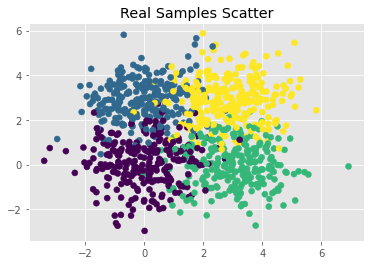

In [6]:
plot_scatter(samples=real_samples, title='Real Samples Scatter', group=groups)

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 2</span>**. Sampling with MCMC: implement the MALA algorithm to draw samples from $p(x;\{\mu_i\})$. The function will get an initial guess $\{\hat x_i\}$ and will generate chains of length $L$. Use $\sqrt{2\varepsilon} = 0.1$ and $N \sim \mathcal{N}(0,I)$.


In [7]:
def log_gradient_p(x, sigma_2=1, 
                        mu=[np.array([0,0]), np.array([0,3]),
                             np.array([3,0]), np.array([3,3])]):
    N = len(mu)
    denominator = 0
    for i in range(N):
        denominator += np.exp((-1/(2*sigma_2)) * np.linalg.norm(x-mu[i], axis=1) ** 2 )
    denominator = np.reshape(denominator, (denominator.shape[0],1))
    
    nominator = 0
    for i in range(N):  
        s = (np.exp((-1/(2*sigma_2)) * np.linalg.norm(x-mu[i], axis=1) ** 2 ))
        d = (mu[i] - x).transpose()
        nominator +=  s * d 
    
    return (1/sigma_2) * nominator.transpose() / denominator

In [8]:
def p(x, sigma_2=1,mu=[np.array([0,0]), np.array([0,3]),
                         np.array([3,0]), np.array([3,3])]):
    N = len(mu)
    sum_exp = 0
    for n in range(N):
        log_exp = -0.5 * (np.linalg.norm(x-mu[n], axis=1) ** 2)
        sum_exp += np.exp(log_exp)
    return (1/N) * (1 /(2*np.pi)) * sum_exp

In [9]:
def q(x_tag, x, epsilon, mu=[np.array([0,0]), np.array([0,3]),
                             np.array([3,0]), np.array([3,3])]):
    norm = np.linalg.norm(x_tag - x - epsilon * log_gradient_p(x, mu=mu), axis=1) ** 2
    log_q = -norm/(4*epsilon)
    q = np.exp(log_q)
    return q

In [10]:
def langevin_mala_dynamics(init_guess, steps=5000, samples=1000, sigma_2=1, factored_epsilon=0.1, 
                           mu=[np.array([0,0]), np.array([0,3]), np.array([3,0]), np.array([3,3])],
                           MALA=False, verbos=False):
    epsilon = (factored_epsilon ** 2) / 2
    x = init_guess
    mala_reg_update = 0
    mala_alpha_update = 0
    mala_no_update = 0
    for s in tqdm.tqdm(range(steps)):
        noise = np.random.randn(x.shape[0], x.shape[1])
        new_x = x + epsilon * log_gradient_p(x, sigma_2=sigma_2, mu=mu) + factored_epsilon * noise
        
        if MALA:
            if p(new_x, mu=mu).sum() > p(x, mu=mu).sum():
                x = new_x.copy()
                mala_reg_update += 1
            else:
                p_x = p(x=x, mu=mu).sum()
                p_x_new = p(x=new_x, mu=mu).sum()
                q_x_x_new = q(x_tag=x, x=new_x, epsilon=epsilon, mu=mu).sum()
                q_x_new_x = q(x_tag=new_x, x=x, epsilon=epsilon, mu=mu).sum()
                alpha = (p_x / p_x_new) * (q_x_x_new / q_x_new_x)
                r = np.random.uniform()
                if r < alpha:
                    x = new_x.copy()
                    mala_alpha_update += 1
                else:
                    mala_no_update += 1
                
        else:
            x = new_x.copy()
    
    if MALA and verbos:
        print(mala_reg_update / steps)
        print(mala_alpha_update / steps)
        print(mala_no_update / steps)
    
    return x

In [11]:
init_guess = np.random.uniform(low=0, high=3, size=(1_000, 2))
x = langevin_mala_dynamics(init_guess=init_guess, steps=10_000, samples=1_000, MALA=False, sigma_2=1)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1809.22it/s]


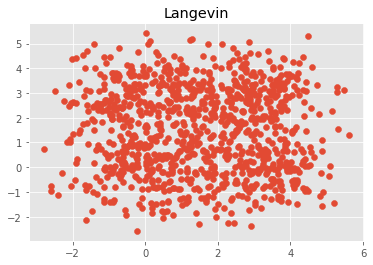

In [12]:
plot_scatter(samples=x, title='Langevin')

In [13]:
init_guess = np.random.uniform(low=0, high=3, size=(1_000, 2))
x = langevin_mala_dynamics(init_guess=init_guess, steps=10_000, samples=1_000, MALA=True, sigma_2=1)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 606.90it/s]


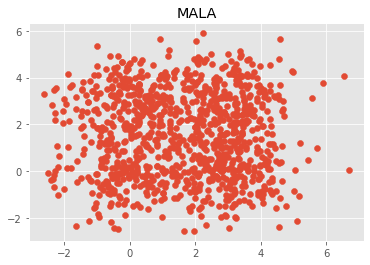

In [14]:
plot_scatter(samples=x, title='MALA')

**From now on**, we will refer to **$\{\mu_i\}$ as unknowns** and we will estimate them using different algorithms.

#### Estimation of $\{\mu_i\}$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 3</span>**. Implement Maximum likelihood (ML) estimation of $\{\mu_i\}$ using direct sampling:
* Step 1: Randomly initialize $\{\tilde \mu_i\}$ from $U([0,3]^2)$.
* Step 2: Use your function from Task 1 to draw 100 samples ${\tilde x}$ from $p(x;\{\mu_i\})$ using $\{\tilde \mu_i\}$.
* Step 3: Update $\{\tilde \mu_i\}$ using the ML gradient descent step:
$$ \tilde \mu_i ^ {k+1} = \tilde \mu_i ^ {k} + \eta\left(\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{x}-\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{\tilde x}\right),$$
where $\langle\cdot\rangle_x$ denotes averaging over the real samples from Task 1 and $\langle\cdot\rangle_{\tilde x}$ denotes averaging over the synthetically generated samples from Step 2. Use $\eta = 1$.
* Repeat Step 2 and Step 3 until convergence.

In [15]:
def grad_mu_log_p(x, mu):
    N = len(mu)
    denominator = 0
    for n in range(N):
        log_exp = -0.5 * (np.linalg.norm(x-mu[n]) ** 2)
        denominator += np.exp(log_exp)
    
    nominator = np.zeros([N,2])
    
    for n in range(N):
        log_exp = -0.5 * (np.linalg.norm(x-mu[n]) ** 2)
        exp = np.exp(log_exp)
        nominator[n] = exp * (x-mu[n])
        
    return (1/denominator) * nominator

In [16]:
def avg_grad_mu_log_p(x, mu):
    grad = np.zeros(shape=mu.shape)
    for x_i in x:
        grad += grad_mu_log_p(x=x_i, mu=mu)
    return grad / x.shape[0]

In [17]:
def ML_DS(N, real_samples, etta=1, draw_mcmc=False, init_task_1=False):
    mu_hat = np.random.uniform(size=[N,2]) * 3
    step_idx = 0
    while True:
        if draw_mcmc:
            if init_task_1:
                init_guess, _ = mix_gauss_draw(N=N, sigma=1, J=100) # using original mu's
                x_hat = langevin_mala_dynamics(init_guess=init_guess, steps=10, samples=100, MALA=True, sigma_2=0.1, factored_epsilon=0.1, mu=mu_hat)
            else:
                init_guess = np.random.randn(100, 2) * np.sqrt(2) + 1.5
                x_hat = langevin_mala_dynamics(init_guess=init_guess, steps=1_000, samples=100, MALA=True, sigma_2=0.1, factored_epsilon=0.1, mu=mu_hat)
        else:
            x_hat, _ = mix_gauss_draw(N=N, sigma=1, mu=mu_hat, J=100)
        avg_mu_grad_estim = avg_grad_mu_log_p(x_hat, mu_hat)
        avg_mu_grad_real = avg_grad_mu_log_p(real_samples, mu_hat)
        
        old_mu = mu_hat.copy()
        mu_hat = mu_hat + etta * (avg_mu_grad_real - avg_mu_grad_estim)
        
        step_norm = np.linalg.norm(mu_hat - old_mu)
        
        if step_norm < 1e-1:
            print(step_norm)
            break
            
        if step_idx % 10 == 0:
            print(step_norm)
        step_idx += 1    
        
    return mu_hat

In [18]:
real_samples, groups = mix_gauss_draw(sigma=1)
estim_mu = ML_DS(N=4, real_samples=real_samples, etta=1)
print("Estimated MU:\n", estim_mu)

0.2558766679562691
0.21107447927951567
0.1263122438198493
0.08803442535979092
Estimated MU:
 [[ 3.01091859  0.03061885]
 [-0.01691787  3.00878443]
 [ 2.9861965   2.99639136]
 [-0.07696866 -0.04974094]]


<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 4</span>**. Implement Maximum likelihood (ML) estimation of $\{\mu_i\}$ using MCMC:
* Step 1: Randomly initialize $\{\tilde \mu_i\}$ from $U([0,3]^2)$.
* Step 2: Use your function from Task 2 to draw 100 samples ${\tilde x}$ from $p(x;\{\mu_i\})$ using $\{\tilde \mu_i\}$. Initialize the chains with $\hat x_i \sim \mathcal{N}(1.5,2)$ and use chains length of $L=1000$.
* Step 3: Update $\{\tilde \mu_i\}$ using the ML gradient descent step:
$$ \tilde \mu_i ^ {k+1} = \tilde \mu_i ^ {k} + \eta\left(\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{x}-\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{\tilde x}\right),$$
where $\langle\cdot\rangle_x$ denotes averaging over the real samples from Task 1 and $\langle\cdot\rangle_{\tilde x}$ denotes averaging over the synthetically generated samples from Step 2. Use $\eta = 1$.
* Repeat Step 2 and Step 3 until convergence.

In [19]:
estim_mu_mala = ML_DS(N=4, real_samples=real_samples, etta=1, draw_mcmc=True)
print("Estimated MU:\n", estim_mu_mala)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1153.55it/s]


0.45575212224887335


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1163.90it/s]


0.12004580897410269


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1097.99it/s]

0.09669773564672267
Estimated MU:
 [[ 2.73926735  3.1403476 ]
 [ 3.07690851  0.132218  ]
 [-0.06140892  0.06579094]
 [-0.10931543  3.10781589]]


<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 5</span>**. Implement Contrastive Divergence (CD) estimation of $\{\mu_i\}$ using MCMC sampling:
* Step 1: Randomly initialize $\{\tilde \mu_i\}$ from $U([0,3]^2)$.
* Step 2: Use your function from Task 2 to draw 100 samples ${\tilde x}$ from $p(x;\{\mu_i\})$ using $\{\tilde \mu_i\}$. Initialize the chains with **100 samples randomly chosen from the real set of examples from Task 1**, and use only $L=10$ update steps.
* Step 3: Update $\{\tilde \mu_i\}$ using the CD gradient descent step:
$$ \tilde \mu_i ^ {k+1} = \tilde \mu_i ^ {k} + \eta\left(\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{x}-\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{\tilde x}\right),$$
where $\langle\cdot\rangle_x$ denotes averaging over the $100$ real samples used for initialization of the chains in Step 2 and $\langle\cdot\rangle_{\tilde x}$ denotes averaging over the MCMC generated samples from Step 3. Use $\eta = 1$.
* Repeat Step 2 and Step 3 until convergence.

In [22]:
estim_mu_mala_init_task_1 = ML_DS(N=4, real_samples=real_samples, etta=1, draw_mcmc=True, init_task_1=True)
print("Estimated MU:\n", estim_mu_mala_init_task_1)

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2486.84it/s]


0.2707670236008407


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1671.37it/s]


0.1205612773427741


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2009.83it/s]


0.09028178109519877
Estimated MU:
 [[ 3.29127853  0.60871475]
 [ 1.08688689 -0.55987471]
 [ 2.44252935  3.45389101]
 [ 0.05760177  2.03691587]]


<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 6</span>**.
Present the estimated $\{\mu_i\}$ and the final random samples $\{\tilde x_i\}$ generated with each of the three algorithms in Tasks 3-5. Discuss the differences in convergence.

In [23]:
import itertools
def calc_diff_mu(mu_hat, mu=[np.array([0,0]), np.array([0,3]), np.array([3,0]), np.array([3,3])]):
    mu = np.array(mu)
    permutations = np.array(list(itertools.permutations(mu_hat)))
    min_tot_err = 1e6
    
    for perm in permutations:
        tot_err = np.linalg.norm(mu-perm) ** 2
        
        if tot_err <  min_tot_err:
            min_tot_err = tot_err
        
    return min_tot_err

In [24]:
print("Task 3:\n", estim_mu)
print("Squared Error: ", calc_diff_mu(mu_hat=estim_mu))
print("\nTask 4:\n", estim_mu_mala)
print("Squared Error: ", calc_diff_mu(mu_hat=estim_mu_mala))
print("\nTask 5:\n", estim_mu_mala_init_task_1)
print("Squared Error: ", calc_diff_mu(mu_hat=estim_mu_mala_init_task_1))

Task 3:
 [[ 3.01091859  0.03061885]
 [-0.01691787  3.00878443]
 [ 2.9861965   2.99639136]
 [-0.07696866 -0.04974094]]
Squared Error:  0.010022005521795623

Task 4:
 [[ 2.73926735  3.1403476 ]
 [ 3.07690851  0.132218  ]
 [-0.06140892  0.06579094]
 [-0.10931543  3.10781589]]
Squared Error:  0.1427491165494605

Task 5:
 [[ 3.29127853  0.60871475]
 [ 1.08688689 -0.55987471]
 [ 2.44252935  3.45389101]
 [ 0.05760177  2.03691587]]
Squared Error:  3.3977992119222185


In [25]:
gen_mu_3, g_3=mix_gauss_draw(mu=estim_mu)
gen_mu_4, g_4=mix_gauss_draw(mu=estim_mu_mala)
gen_mu_5, g_5=mix_gauss_draw(mu=estim_mu_mala_init_task_1)

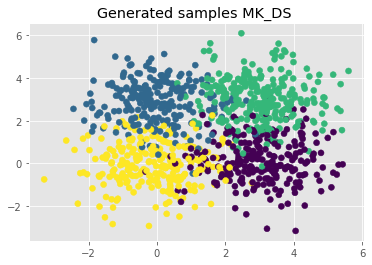

In [26]:
plot_scatter(samples=gen_mu_3, title='Generated samples MK_DS ', group=g_3)

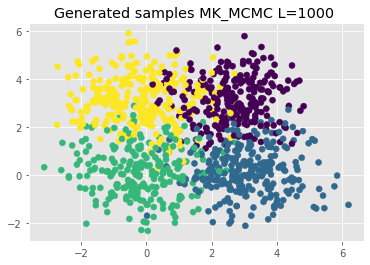

In [27]:
plot_scatter(samples=gen_mu_4, title='Generated samples MK_MCMC L=1000 ', group=g_4)

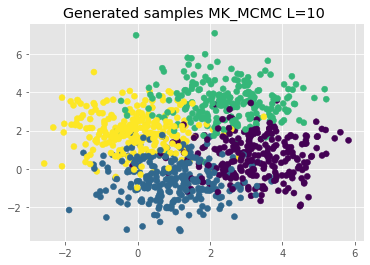

In [28]:
plot_scatter(samples=gen_mu_5, title='Generated samples MK_MCMC L=10 ', group=g_5)

## $\color{#007FFF}{\textbf{Discussion:}}$

From the plots it's very hard to see any pattern even on the real data. So, to distinguish between the generated samples is even harder. $$ $$
In order to estimate the diffrences beween the $\hat{\mu}$ we calculated the squared error beween each one and the real $\mu$. Results shows as excpected that the ML estimation based on the real results are the best and the generated samples based on L=10 are worse that generated MCMC samples based on L=1000 as excpected since the L=10 will not converge as good to the real data distribution as L=1000.


## Part II: Noise Contrastive Estimation (50 points)

Consider the distribution
$$p_m(x;\{\mu_i\}) = \frac{1}{Z} \sum_{i=1}^{N} \exp\left\{-\frac{1}{2\sigma^2}||x-\mu_i||^2\right\} ,$$	
where $Z \in \mathbb{R}$ is a normalization constant, and $ x,\mu_i \in \mathbb{R}^2$.

#### Sampling from GMM

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 7</span>**. What is the value of $Z$?


Easy to see that: $ \Sigma = I\sigma^2$
$$ \Rightarrow \frac{1}{Z} = \frac{1}{N}\cdot\det(2\pi\Sigma)^{-1/2}=\frac{1}{2\pi N\sigma^2} $$ 
$$ \Rightarrow Z = 2\pi N\sigma^2 $$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 8</span>**. Use $N = 4$, $\sigma = 1$, and $\{\mu_i\} = \{(0,0)^T , (0,3)^T , (3,0)^T , (3,3)^T\} $. Draw $J=1000$ samples $\{x_j\}$ from the distribution $p_m(x;\{\mu_i\})$ using the function from Task 1.

In [29]:
real_samples, groups = mix_gauss_draw(N=4, sigma=1, mu=[np.array([0,0]),
                                     np.array([0,3]),
                                     np.array([3,0]),
                                     np.array([3,3])], J=1_000)

**From now on**, we will refer to **$\{\mu_i\}$ as unknowns** and we will estimate them using the Noise Contrastive Estimation method.

#### Estimation of $\{\mu_i\}$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 9</span>**. Implement Noise Contrastive Estimation of $\{\mu_i\}$:
* Step 1: Generating the artificial data-set of noise: Draw $J=1000$ samples $\{y_j\}$ from $$p_n(y;\mu_n) = \frac{1}{{{2\pi \sigma_n^2}}} \exp\left\{-\frac{1}{2\sigma_n^2}||y-\mu_n||^2\right\}$$
  using $\mu_n = (1,1)^T$ and $\sigma_n=2$.
* Step 2: Randomly select an initial guess for the model means $\{\tilde \mu_i\}$ from $U([0,3]^2)$.
* Step 3: Update $\{\tilde \mu_i\}$ by **maximizing**:
$$\{\tilde \mu_i\} = \underset{\{\mu_i\}}{\arg\max} \, \sum_{j=1}^{J} \left[\ln (h(x_j;\{\mu_i\})) + \ln(1-h(y_j;\{\mu_i\})) \right],$$
where
$$h(u;\{\mu_i\}) = \frac{p_m(u;\{\mu_i\})}{p_m(u;\{\mu_i\})+p_n(u;\mu_n)}.$$
  Implementation Tip: This step can be executed using the function `scipy.optimize.minimize` which finds the **minimum** of an (unconstrained) optimization problem (e.g. using the `'BFGS'` method), given a function that calculates the objective and an initial guess (see scipy documentation for more details). In our case, for **maximization**, implement a function that calculates the **minus** of the objective above.

In [30]:
def p(x, sigma_squared, means_vec, Z=None):
    N = len(means_vec)
    if Z is None:
        Z = N*2*np.pi*sigma_squared

    sum_exp = 0
    for n in range(N):
        log_exp = -(0.5/sigma_squared) * (np.linalg.norm(x-means_vec[n], axis=1) ** 2)
        sum_exp += np.exp(log_exp)
    return 1/Z * sum_exp


def h(x, mu, Z = None):
    pm = p(x=x, sigma_squared=1,means_vec=mu, Z=Z)
    pn = p(x=x, sigma_squared=4,means_vec=np.array([1,1]))
    return pm/(pm+pn)

def objective(params, *args):

    sum = 0
    real_samples, noise_samples = args[0], args[1]

    mu = params.reshape(-1,2)
    sum = np.sum(np.log(h(x=real_samples, mu=mu)) + np.log(1-h(x=noise_samples, mu=mu)))
    return -sum

In [31]:
J = 1000
sigma_n=2
mu_n=[np.array([1,1])]
noise_samples_9 = np.random.randn(J, 2) * np.sqrt(sigma_n) + 1
mu_hat_9 = np.random.uniform(size=[4,2]) * 3

In [32]:
results = minimize(method='BFGS', fun=objective, x0=mu_hat_9, args=(real_samples, noise_samples_9)) #, options={'gtol': 1e-5})
mu_task_9 = results.x.reshape(-1,2)
print(mu_task_9)

[[-0.37680239 -0.2867889 ]
 [-0.36224257  3.48330967]
 [ 3.22317244  3.04671973]
 [ 3.26963204 -0.16830731]]


We will now regard both $\{\mu_i\}$ **and the normalization constant $Z$** as unknowns, and will estimate them using Noise Contrastive Estimation.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 10</span>**. Implement Noise Contrastive Estimation with an **un-normalized** probability model:
* Step 1: Generating the artificial data-set of noise: Draw $J=1000$ samples $\{y_j\}$ from $$p_n(y;\mu_n) = \frac{1}{{{2\pi \sigma_n^2}}} \exp\left\{-\frac{1}{2\sigma_n^2}||y-\mu_n||^2\right\}$$
  using $\mu_n = (1,1)^T$ and $\sigma_n=2$.
* Step 2: Randomly select an initial guess for the model means $\{\tilde \mu_i\}$ from $U([0,3]^2)$, and for the normalization constant $Z$ from $U([0.1,1])$
* Step 3: Update $\{\tilde \mu_i\}$ and $Z$ by **maximizing**:
$$\{\tilde \mu_i\}, Z = \underset{\{\mu_i\}, Z}{\arg\max} \, \sum_{j=1}^{J} \left[\ln (h(x_j;\{\mu_i\}, Z)) + \ln(1-h(y_j;\{\mu_i\}, Z)) \right],$$
where
$$h(u;\{\mu_i\}, Z) = \frac{p_m(u;\{\mu_i\}, Z)}{p_m(u;\{\mu_i\}, Z)+p_n(u;\mu_n)}.$$

In [33]:
def Objective_Z(params, *args): 
    obj_sum = 0
    real_samples, noise_samples = args[0], args[1]
    mu_hat = params[:-1].reshape(-1,2)
    Z = params[-1]
    obj_sum = np.sum(np.log(h(x=real_samples, mu=mu_hat, Z=Z)) + np.log(1-h(x=noise_samples, mu=mu_hat, Z=Z)))

    return -obj_sum

In [46]:
J = 1000
sigma=2
mu=[np.array([1,1])]
noise_samples_10 = np.random.randn(J, 2) * np.sqrt(2) + 1
mu_hat_10 = np.random.uniform(size=[4,2]) * 3
Z_10 = np.random.uniform() * 0.9 + 0.1
mu_hat_Z = np.append(mu_hat_10, Z_10)

In [47]:
results_Z = minimize(method='BFGS', fun=Objective_Z, x0=mu_hat_Z, args=(real_samples, noise_samples_10))
mu_task_10 = results_Z.x[:8].reshape(-1,2)
Z_task_10 = results_Z.x[8]
print(Z_task_10)
print(mu_task_10)

19.623383237463372
[[-0.19051958 -0.55742932]
 [-0.38375688  3.44490873]
 [ 3.46101388  3.29148425]
 [ 3.50002984 -0.0390691 ]]


#### Evaluating the Results

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 11</span>**. Visually: plot the estimates of $\{\mu_i\}$ of Tasks 9 and 10 (two separate figures). Include the model samples, the noise samples, the initial guess for the model means, and the final estimates of $\{\tilde \mu_i\}$.

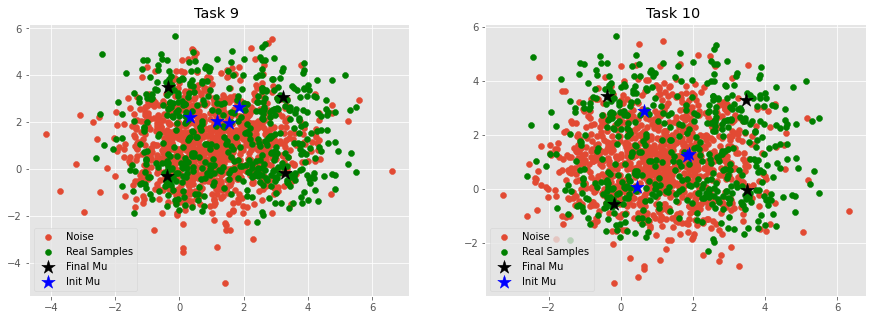

In [48]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0].scatter(noise_samples_9[:,0], noise_samples_9[:,1], label='Noise')
axes[0].scatter(real_samples[0:500][:,0], real_samples[0:500][:,1], c='green', label='Real Samples')
axes[0].scatter(mu_task_9[:,0], mu_task_9[:,1], marker="*", s=200, c='black', label='Final Mu')
axes[0].scatter(mu_hat_9[:,0], mu_hat_9[:,1], marker="*", s=200, c='blue', label='Init Mu')
axes[0].set_title('Task 9 ')
axes[0].legend()

axes[1].scatter(noise_samples_10[:,0], noise_samples_10[:,1], label='Noise')
axes[1].scatter(real_samples[0:500][:,0], real_samples[0:500][:,1], c='green', label='Real Samples')
axes[1].scatter(mu_task_10[:,0], mu_task_10[:,1], marker="*", s=200, c='black', label='Final Mu')
axes[1].scatter(mu_hat_10[:,0], mu_hat_10[:,1], marker="*", s=200, c='blue', label='Init Mu')
axes[1].set_title('Task 10 ')
axes[1].legend()

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 12</span>**. Quantitatively: repeat Tasks 9 and 10, this time with $J = 100\times[1,5,10,20,30,50]$. For each value of $J$ repeat the estimation process for 50 times, each time with different realizations for $\{x_j\}$ and $\{y_j\}$ and initial guesses for the estimands ($\{\mu_i\}$ in Task 9 and $\{\mu_i\},Z$ in Task 10. 

For each value of $J$, calculate the MSE between the true parameter values and their estimates (the mean will be taken over the different realizations). Note that for the model means, the MSE should be calculated to the closest true $\mu_i$ for each estimation. If at the same run two estimated $\mu_i$s pick the same true $\mu_i$, then this run should be declared as a failure and should be disregarded. Report the number of failure runs.

In [97]:
def calc_dist(mu_hat, mu=np.array([[0,0],[0,3],[3,0],[3,3]])):
    map_order = {}
    err = 0
    for idx, m in enumerate(mu_hat):
        err += np.min(np.linalg.norm(mu-m, axis=1) ** 2)
        map_order[idx] = np.argmin(np.linalg.norm(mu-m, axis=1) ** 2)
    
    if not len(set(map_order.values())) == len(map_order):
        return False, err
    
    return True, err

In [101]:
dic_res = {}
for J in [100, 150, 1_000, 2_000, 3_000, 5_000]:
    
    num_fail_9 = 0
    num_fail_10 = 0
    
    tot_err_9 = 0
    tot_err_10 = 0
    
    for i in tqdm.tqdm(range(50)):
        real_samples, groups = mix_gauss_draw(N=4, sigma=1, mu=[np.array([0,0]),
                                         np.array([0,3]),
                                         np.array([3,0]),
                                         np.array([3,3])], J=J)

        noise_samples_9 = np.random.randn(J, 2) * np.sqrt(2) + 1
        mu_hat_9 = np.random.uniform(size=[4,2]) * 3
        
        results = minimize(method='BFGS', fun=objective, x0=mu_hat_9, args=(real_samples, noise_samples_9))
        mu_task_9 = results.x.reshape(-1,2)
        
        suc, err = calc_dist(mu_task_9)
        num_fail_9 += int(not(suc))
        tot_err_9 += err

        noise_samples_10 = np.random.randn(J, 2) * np.sqrt(2) + 1
        mu_hat_10 = np.random.uniform(size=[4,2]) * 3
        Z_10 = np.random.uniform() * 0.9 + 0.1
        mu_hat_Z = np.append(mu_hat_10, Z_10)

        results_Z = minimize(method='BFGS', fun=Objective_Z, x0=mu_hat_Z, args=(real_samples, noise_samples_10))
        mu_task_10 = results_Z.x[:8].reshape(-1,2)
        Z_task_10 = results_Z.x[8]
        
        suc, err = calc_dist(mu_task_10)
        num_fail_10 += int(not(suc))
        tot_err_10 += err
        
    
    dic_res[(9, J)] = (num_fail_9, tot_err_9)
    dic_res[(10, J)] = (num_fail_10, tot_err_10)
    

 10%|████████▎                                                                          | 5/50 [00:01<00:08,  5.01it/s]C:\Users\neria\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\neria\anaconda3\envs\deep_learn\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\neria\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\neria\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:05<00:05,  4.15it/s]C:\Users\neria\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
C:\Users\neria\a

In [106]:
nine_task_j_acc = {}
ten_task_j_acc = {}
for key, val in dic_res.items():
    print("Task:", key[0], "J=", key[1])
    print("Failuers:", val[0], "Avg Err:", val[1]/(50-val[0]))
    
    if key[0] == 9:
        nine_task_j_acc[key[1]] = val[1]/(50-val[0])
    if key[0] == 10:
        ten_task_j_acc[key[1]] = val[1]/(50-val[0])
        
    print("="*10)

Task: 9 J= 100
Failuers: 2 Avg Err: 2.5393292646359957
Task: 10 J= 100
Failuers: 20 Avg Err: 566.2526486742096
Task: 9 J= 150
Failuers: 0 Avg Err: 1.6880837649611724
Task: 10 J= 150
Failuers: 26 Avg Err: 2646.624648537139
Task: 9 J= 1000
Failuers: 0 Avg Err: 0.7642552780696296
Task: 10 J= 1000
Failuers: 24 Avg Err: 14442.679453818524
Task: 9 J= 2000
Failuers: 0 Avg Err: 0.696888466449651
Task: 10 J= 2000
Failuers: 29 Avg Err: 50842.81310065304
Task: 9 J= 3000
Failuers: 0 Avg Err: 0.678179897579023
Task: 10 J= 3000
Failuers: 27 Avg Err: 39854.68709802683
Task: 9 J= 5000
Failuers: 0 Avg Err: 0.6487374382663149
Task: 10 J= 5000
Failuers: 34 Avg Err: 135038.9161081356


<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 13</span>**. Discussion: How does the number of samples $J$ affect the accuracy of the estimation? How does the addition of $Z$ as an unknown affect the accuracy? 

Text(0, 0.5, 'Avg Err')

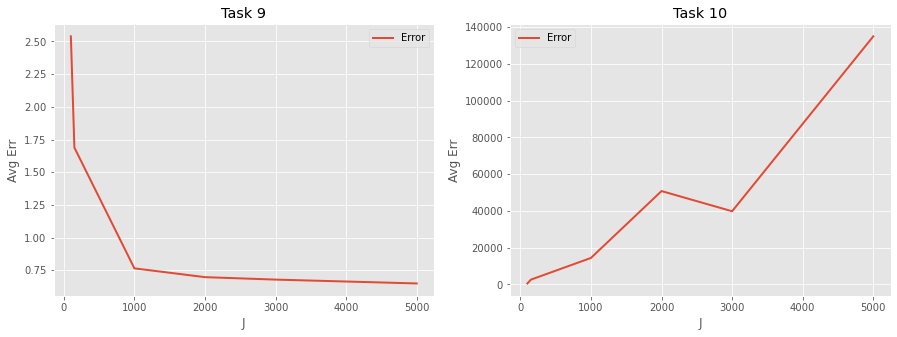

In [126]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[1].plot(list(ten_task_j_acc.keys()), list(ten_task_j_acc.values()), label="Error")
axes[1].legend()
axes[1].set_title("Task 10")
axes[1].set_xlabel("J")
axes[1].set_ylabel("Avg Err")

axes[0].plot(list(nine_task_j_acc.keys()), list(nine_task_j_acc.values()), label="Error")
axes[0].legend()
axes[0].set_title("Task 9")
axes[0].set_xlabel("J")
axes[0].set_ylabel("Avg Err")

## $\color{#007FFF}{\textbf{Discussion:}}$

In case we know Z the error decrease with J. $$ $$
In the other case where Z need to be estimated we both have higher number of errors and worst error duo to stabillity issues.
